In [1]:
import gymnasium
import torch
import os
import numpy as np
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from datetime import date, datetime
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common.results_plotter import plot_results
from stable_baselines3.common import results_plotter
from src import helpers
import importlib
from src.definitions import PROJECT_ROOT
from src.ant.BipedalAntWrapper import BipedalAntWrapper
import gymnasium
from src import render_model_gym


In [2]:
n_envs = 7
start_time_suffix = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_dir = f"logs/monitor_{start_time_suffix}/"


print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"MuJoCo version: {mujoco.__version__}")

xml_path = os.path.join(PROJECT_ROOT, "animals", "ant.xml")

# Verify model loads correctly
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(f"Model loaded: {model.nq} DOFs, {model.nu} actuators")

PyTorch CUDA available: True
MuJoCo version: 3.4.0
Model loaded: 15 DOFs, 8 actuators


# MuJoCo Native Training Setup (CPU Optimized)
Using native MuJoCo simulation with vectorized environments for maximum CPU throughput.


In [3]:
vec_env = make_vec_env(
    "Ant-v5",
    n_envs=n_envs,
    env_kwargs={"xml_file": xml_path},
    vec_env_cls=SubprocVecEnv,
    monitor_dir=log_dir,
)

print(f"Created {n_envs} parallel environments")

Created 7 parallel environments


In [4]:
vec_env = VecMonitor(vec_env, log_dir)

model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    device="cpu",  # Force CPU
    n_steps=2048,
    batch_size=256,  # Smaller batch for CPU
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.0,
    learning_rate=3e-4,
)

model.learn(total_timesteps=6_000_000)

Using cpu device


c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 96.2     |
|    ep_rew_mean     | -104     |
| time/              |          |
|    fps             | 4323     |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 14336    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 143          |
|    ep_rew_mean          | -149         |
| time/                   |              |
|    fps                  | 3997         |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0091664465 |
|    clip_fraction        | 0.0739       |
|    clip_range           | 0.2          |
|    entropy_loss         | -11.3        |
|    explained_variance   | -0.0026      |
|    learning_r

- model trains well after 4 million timestamps

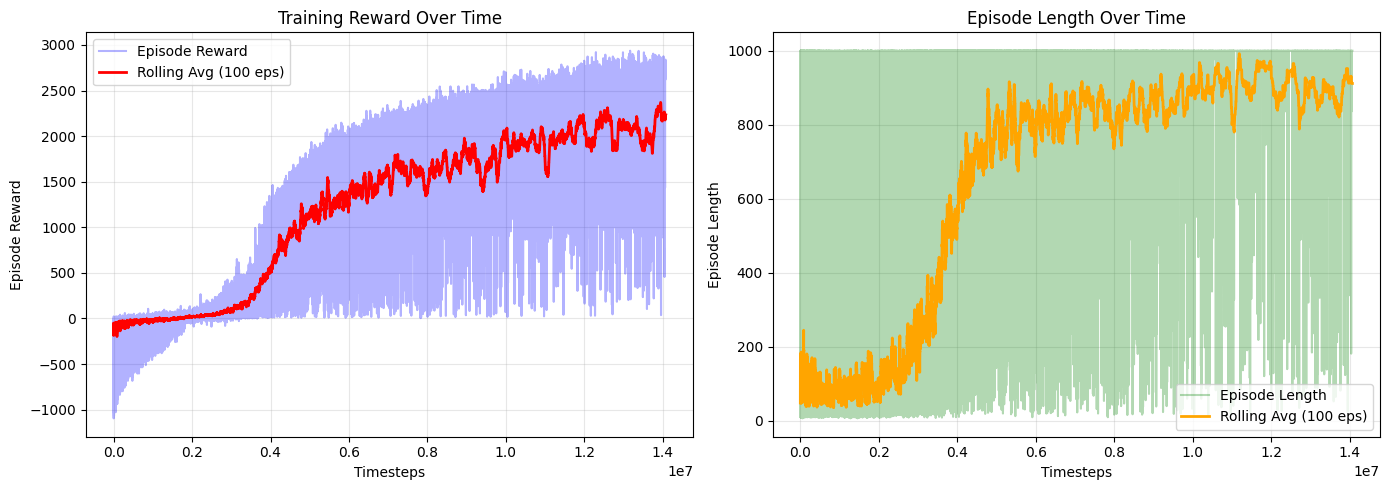

(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'Training Reward Over Time'}, xlabel='Timesteps', ylabel='Episode Reward'>,
        <Axes: title={'center': 'Episode Length Over Time'}, xlabel='Timesteps', ylabel='Episode Length'>],
       dtype=object))

In [5]:
importlib.reload(helpers)
df = load_results(log_dir)
helpers.plot_training_progress(df)

In [6]:
model_name = f"ppo_ant_{start_time_suffix}"

model.save(os.path.join(PROJECT_ROOT, "trained_models", model_name))
vec_env.close()

print(f"Model saved to trained_models/{model_name}")

Model saved to trained_models/ppo_ant_2026-01-08_22-07


# Bipedal ant

In [7]:


# Training settings for bipedal ant
bipedal_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
bipedal_log_dir = f"logs/bipedal_monitor_{bipedal_start_time}/"

# Create environment with wrapper_class instead of custom factory
# This is more compatible with SubprocVecEnv on Windows
bipedal_vec_env = make_vec_env(
    "Ant-v5",
    n_envs=n_envs,
    env_kwargs={"xml_file": xml_path},
    vec_env_cls=SubprocVecEnv,
    monitor_dir=bipedal_log_dir,
    wrapper_class=BipedalAntWrapper,
    wrapper_kwargs={"allowed_legs": [0, 1], "contact_penalty": -10.0},
)

print(f"Created {n_envs} parallel bipedal ant environments")

Created 7 parallel bipedal ant environments


In [8]:
bipedal_vec_env = VecMonitor(bipedal_vec_env, bipedal_log_dir)

bipedal_model = PPO(
    "MlpPolicy",
    bipedal_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=256,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,  # Slightly higher entropy for exploration
    learning_rate=3e-4,
)

# Train longer since bipedal walking is harder
bipedal_model.learn(total_timesteps=10_000_000)

Using cpu device


c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 121      |
|    ep_rew_mean     | -128     |
| time/              |          |
|    fps             | 5880     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 103         |
|    ep_rew_mean          | -107        |
| time/                   |             |
|    fps                  | 4566        |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.010017405 |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | -11.3       |
|    explained_variance   | -0.0153     |
|    learning_rate        | 0.

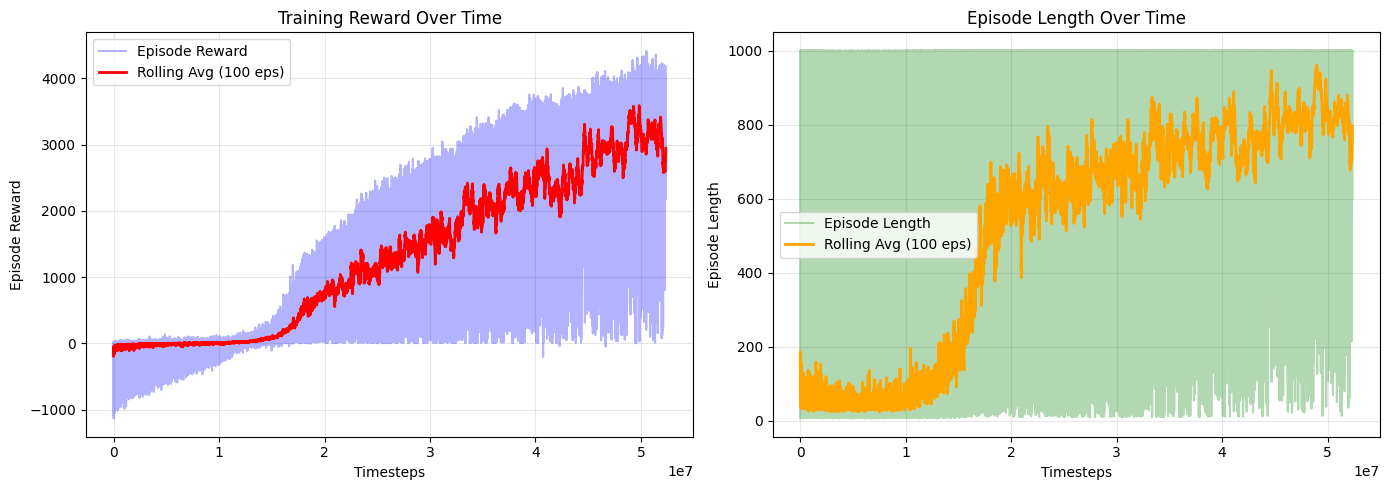

(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'Training Reward Over Time'}, xlabel='Timesteps', ylabel='Episode Reward'>,
        <Axes: title={'center': 'Episode Length Over Time'}, xlabel='Timesteps', ylabel='Episode Length'>],
       dtype=object))

In [9]:
# Plot training progress
bipedal_df = load_results(bipedal_log_dir)
helpers.plot_training_progress(bipedal_df)

In [10]:
# Save the bipedal model
bipedal_model_name = f"ppo_bipedal_ant_{bipedal_start_time}"
bipedal_path = os.path.join(PROJECT_ROOT, "trained_models", bipedal_model_name)
bipedal_model.save(bipedal_path)
bipedal_vec_env.close()

print(f"Bipedal model saved to trained_models/{bipedal_model_name}")

Bipedal model saved to trained_models/ppo_bipedal_ant_2026-01-08_22-32


 - The model is capable of isolating a single limb

# Transfer training

In [11]:
bipedal_vec_env = VecMonitor(bipedal_vec_env, bipedal_log_dir)
transfer_log_dir = f"logs/transfer_monitor_{bipedal_start_time}/"


transfer_log_dir_vec_env = make_vec_env(
    "Ant-v5",
    n_envs=n_envs,
    env_kwargs={"xml_file": xml_path},
    vec_env_cls=SubprocVecEnv,
    monitor_dir=transfer_log_dir,
    wrapper_class=BipedalAntWrapper,
    wrapper_kwargs={"allowed_legs": [0, 1], "contact_penalty": -2.0},
)

# Load the pretrained quadruped model as starting point
pretrained_model_path = os.path.join(PROJECT_ROOT, "trained_models", "ppo_ant_2026-01-08_17-27")
bipedal_model = PPO.load(
    pretrained_model_path,
    env=transfer_log_dir_vec_env,
    device="cpu",
    monitor_dir=transfer_log_dir,
    # Override some hyperparameters for fine-tuning
    custom_objects={
        "learning_rate": 3e-4,  
        "ent_coef": 0.01,  # Higher entropy to encourage exploration of new behavior
    }
)

print(f"Loaded pretrained model from {pretrained_model_path}")
print("Starting fine-tuning for bipedal walking...")

# Train longer since bipedal walking is harder
bipedal_model.learn(total_timesteps=6_000_000)

BrokenPipeError: [WinError 232] The pipe is being closed

In [ ]:
transfer_model_name = f"ppo_bipedal_ant_{bipedal_start_time}"
bipedal_path = os.path.join(PROJECT_ROOT, "trained_models", transfer_model_name)
bipedal_model.save(bipedal_path)
bipedal_vec_env.close()

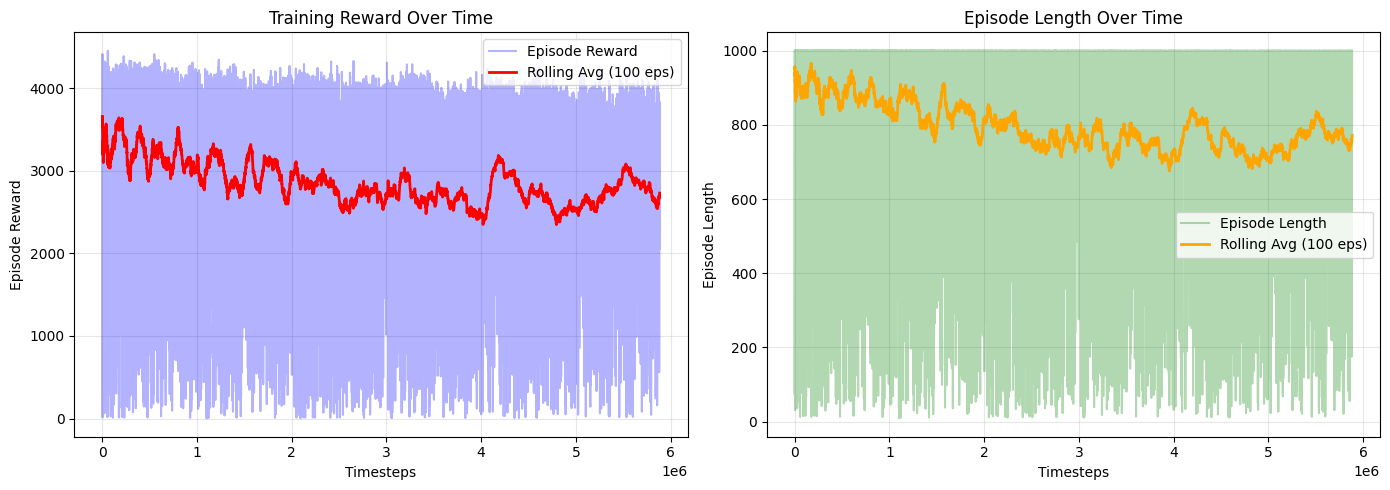

(<Figure size 1400x500 with 2 Axes>,
 array([<Axes: title={'center': 'Training Reward Over Time'}, xlabel='Timesteps', ylabel='Episode Reward'>,
        <Axes: title={'center': 'Episode Length Over Time'}, xlabel='Timesteps', ylabel='Episode Length'>],
       dtype=object))

In [ ]:
transfer_df = load_results(transfer_log_dir)
helpers.plot_training_progress(transfer_df)